In [80]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [81]:
df = pd.read_csv('../pyportfolio/portfolioBestSharpe.csv')
# df.set_index(['Date'], inplace=True)
stock = df
stock

,Date,netDailyChange,Portfolio Value
0,2009-01-02,0.042705,1.000000e+05
1,2009-01-05,0.031782,1.031782e+05
2,2009-01-06,0.011822,1.043979e+05
3,2009-01-07,-0.023851,1.019079e+05
4,2009-01-08,0.011562,1.030862e+05
...,...,...,...
2511,2018-12-24,-0.026028,1.631418e+06
2512,2018-12-26,0.061571,1.731866e+06
2513,2018-12-27,0.001433,1.734349e+06
2514,2018-12-28,-0.001122,1.732403e+06


## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [82]:
stock.drop(['netDailyChange'], axis=1, inplace=True) #needs to be inplace otherwise won't mutate the stock object
stock = stock.sort_values('Date')
stock

,Date,Portfolio Value
0,2009-01-02,1.000000e+05
1,2009-01-05,1.031782e+05
2,2009-01-06,1.043979e+05
3,2009-01-07,1.019079e+05
4,2009-01-08,1.030862e+05
...,...,...
2511,2018-12-24,1.631418e+06
2512,2018-12-26,1.731866e+06
2513,2018-12-27,1.734349e+06
2514,2018-12-28,1.732403e+06


In [83]:
stock.isnull().sum()

Date               0
Portfolio Value    0
dtype: int64

In [84]:
stock = stock.groupby('Date')['Portfolio Value'].sum().reset_index()
stock

,Date,Portfolio Value
0,2009-01-02,1.000000e+05
1,2009-01-05,1.031782e+05
2,2009-01-06,1.043979e+05
3,2009-01-07,1.019079e+05
4,2009-01-08,1.030862e+05
...,...,...
2511,2018-12-24,1.631418e+06
2512,2018-12-26,1.731866e+06
2513,2018-12-27,1.734349e+06
2514,2018-12-28,1.732403e+06


In [85]:
stock = stock.set_index('Date')
stock.index

Index(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
       '2009-01-09', '2009-01-12', '2009-01-13', '2009-01-14', '2009-01-15',
       ...
       '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
       '2018-12-24', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-31'],
      dtype='object', name='Date', length=2516)

In [86]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock['Portfolio Value'].resample('M').mean()

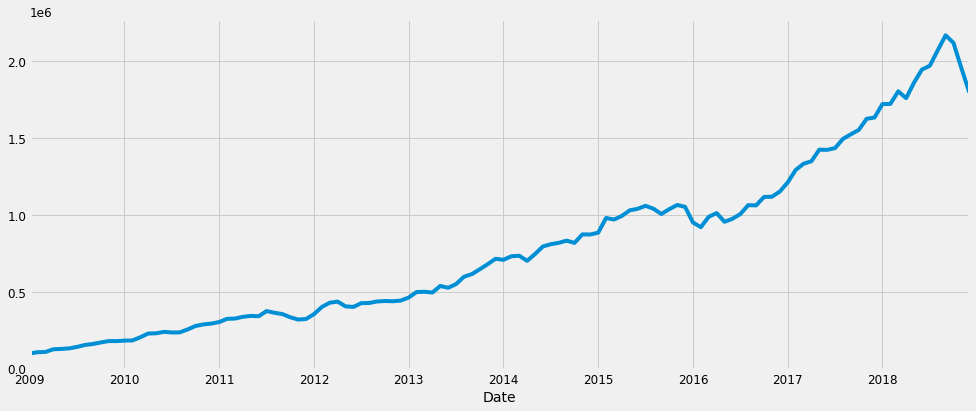

In [87]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

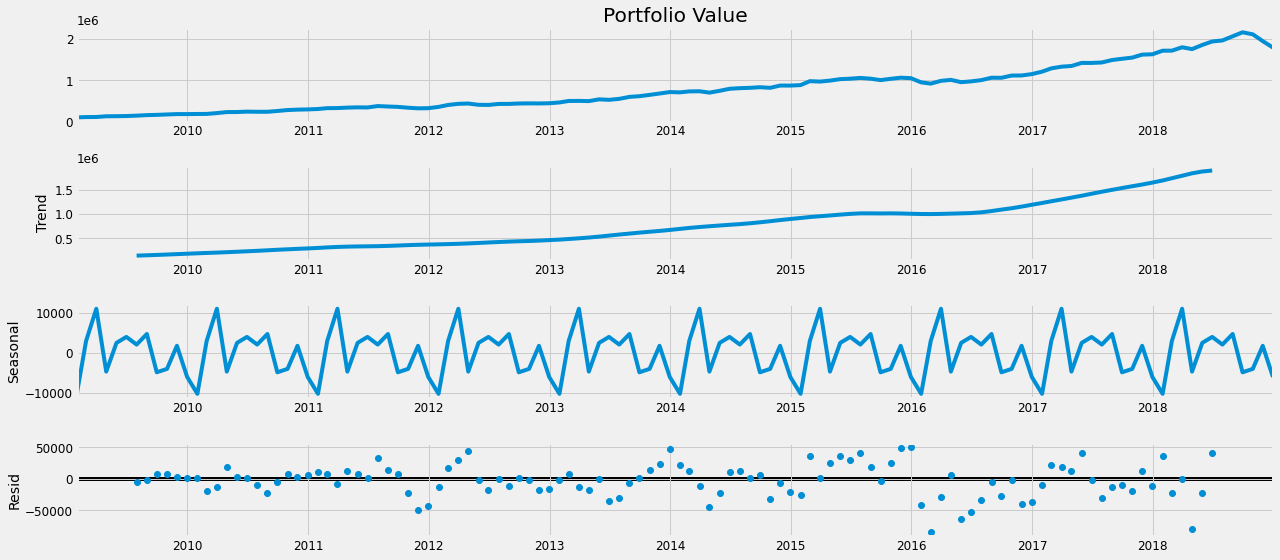

In [88]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:`

In [89]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print('pdq =', pdq)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('seasonal_pdq ', seasonal_pdq)

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

pdq = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
seasonal_pdq  [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

In [91]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

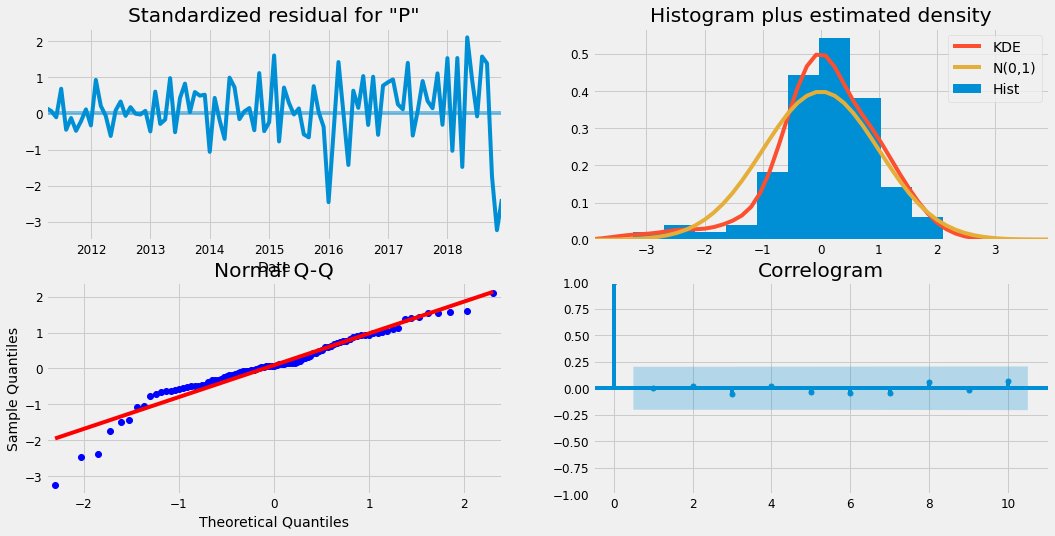

In [93]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

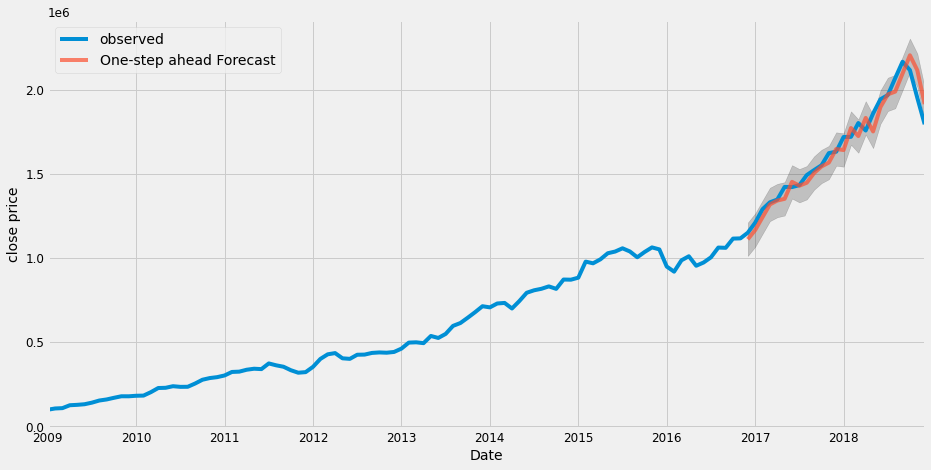

In [125]:
pred = results.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False) # prediction start date
pred_ci = pred.conf_int()

ax = monthly_mean['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

In [126]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 7275649045.09
The Root Mean Squared Error of our forecasts is 85297.42


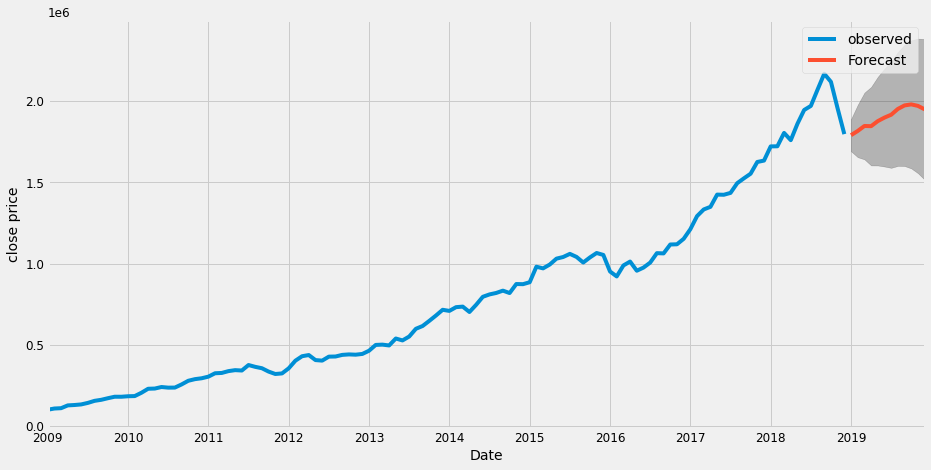

In [127]:
pred_uc = results.get_forecast(steps=12) # each step is 1 month. 12 to predict 1 year
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()